In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

In [2]:
reader = csv.reader(open("hepatitis_2_csv.csv", "r"))
x = list(reader)
res = np.array(x).astype("float")

In [3]:
training_class_name=res[0:568,19:20];
training_data=res[0:568,0:19];
training_data=np.matrix(training_data)
training_data=training_data.transpose()
training_class_name=np.matrix(training_class_name)
training_class_name=training_class_name.transpose()
print(np.prod(list(training_class_name[0].shape)))
print(training_data.shape)

568
(19, 568)


In [4]:
meanData=training_data.mean()
varianceData=np.var(training_data)
training_data=(training_data-meanData)/varianceData

In [223]:
class Net:
    def __init__(self):
        self.weights=[];
        self.bias=[];
        self.status=[];
        self.a=[[[]]];
        self.z=[[[]]];
        self.da=[[[]]];
        self.dz=[[[]]];
        self.dw=[[[]]];
        self.db=[[[]]];
        self.cost=[];
        self.trainingOutput=[[[]]];
        self.correctOutput=[[[]]];
        self.size=0;
        self.vw=[];
        self.vb=[];
        self.sw=[];
        self.sb=[];
        self.vwcorrected=[];
        self.vbcorrected=[];
        self.swcorrected=[];
        self.sbcorrected=[];
        self.dwforgrad=[];
        self.dbforgrad=[];
        
    def model(self,layers):
        self.layers=layers
        self.status.append("Model archetecture recieved")
        self.createBrain()
        self.status.append("Model archetecture created")
        return self.layers
    
    def createBrain(self):
        inputshape = self.layers[0].getshape()
        self.weights.append(0.01*np.random.rand(self.layers[1].getparams()["noOfUnits"],inputshape[0]))
        self.bias.append(np.ones([self.layers[1].getparams()["noOfUnits"],inputshape[1]]))
        print("layer 1 has bias shape as {} and weights shape as {}".format(self.bias[0].shape,self.weights[0].shape))
        for i in range(2,len(self.layers)):
            lowerlimit=self.layers[i].getparams()["noOfUnits"]
            upperlimit=self.layers[i-1].getparams()["noOfUnits"]
            self.weights.append(0.01*np.random.rand(lowerlimit,upperlimit))
            self.bias.append(np.ones([lowerlimit,inputshape[1]]))
            print("layer {} has bias shape as {} and weights shape as {}".format(i,self.bias[i-1].shape,self.weights[i-1].shape))
    
    def train(self,traindata,trainoutcome,hyperparams):
        
        numberOfExamples = np.prod(list(training_class_name[0].shape))   
        epochs=hyperparams["epochs"]
        self.epochs=np.asmatrix(np.arange(0,epochs,1))
        democost=0
        
        if(hyperparams["Batch_size"]>0):
            minibatch=True
            size=hyperparams["Batch_size"]
        
            if(minibatch):
                self.bias[0]=np.ones([self.layers[1].getparams()["noOfUnits"],size])
                for i in range(1,len(self.layers)):
                    lowerlimit=self.layers[i].getparams()["noOfUnits"]
                    self.bias[i-1]=np.ones([lowerlimit,size])

                minibatches = self.make_mini_batches(numberOfExamples,traindata,trainoutcome,30)
        else:
            minibatches = [[(traindata),(trainoutcome)]]
            
        # initialize loss and accuracy lists
        self.loss = np.zeros([1, epochs])
        self.accuracy = np.zeros([1, epochs])
        lv=0;
        av=0;
            
        for i in range(0,epochs):

            
            for j in range(0,len(minibatches)):                              
                # Select a minibatch
                (traindata, trainclass) = minibatches[j]
                self.size = traindata.shape[1] 
                op = self.forewardProp(numberOfExamples,traindata,trainclass,i,j)
                val = op["val"]
                               
                if(self.layers[1].getparams()["activation"]=="sigmoid"):
                    val=val>=0.499
                elif(self.layers[1].getparams()["activation"]=="tanh" or self.layers[1].getparams()["activation"]=="relu"):
                    val=val>=0
                 
                democost=democost+op["cost"]
                
                self.trainingOutput[i][j].append(val)
                self.correctOutput[i][j].append(trainclass)
                self.status.append("Foreward Propogation for batch {} in epoch {} is completed".format(j,i))
                self.backwardProp(numberOfExamples,trainclass,i,j,hyperparams)
                self.status.append("Backward Propogation for batch {} in epoch {} is completed".format(j,i))
                self.da[i].append([])
                self.a[i].append([])
                self.z[i].append([])
                self.dz[i].append([])
                self.dw[i].append([])
                self.db[i].append([])
                self.trainingOutput[i].append([])
                self.correctOutput[i].append([])
                # compute loss
                ls = trainclass - val
                lossval = np.sum(ls)
                lossval=lossval/len(ls[0])
                lv = lv + lossval 
                # compute accuracy
                ac = np.sum(trainclass==val)
                #print(trainclass==val)
                #print(ac)
                accuracyval = ac/len(trainclass)
                av = av + accuracyval

                
            self.cost.append(democost) 
            print("cost for epoch {} is {}".format(i,democost))  
            democost=0
            self.status.append("Foreward Propogation for epoch {} is completed".format(i))
            self.status.append("Backward Propogation for epoch {} is completed".format(i))                  
            self.da.append([[]])
            self.dz.append([[]])
            self.dw.append([[]])
            self.db.append([[]])
            self.a.append([[]])
            self.z.append([[]])
            self.trainingOutput.append([[]])
            self.correctOutput.append([[]])
            #print(i)
            #print("loss = {} accuracy = {}".format(lv/len(minibatches),av/len(minibatches)))
            self.loss[0][i] = lv/len(minibatches)
            self.accuracy[0][i] = av/len(minibatches)
            #print("self.loss = {} and self.accuracy = {}".format(self.loss[0][i],self.accuracy[0][i]))
            lv = 0;
            av = 0;
            
            
        #self.trainingOutput=np.asarray(self.trainingOutput)
        #self.correctOutput=np.asarray(self.correctOutput)
        #self.dz=np.asarray(self.dz)
        #self.dw=np.asarray(self.dw)
        #self.db=np.asarray(self.db)
        #self.da=np.asarray(self.da)

    
    def forewardProp(self,m,traindata,trainoutcome,iterno,batch):
        self.a[iterno][batch].append(traindata)
        z=self.weights[0]*traindata+self.bias[0][:,np.arange(0,self.size)]
        self.z[iterno][batch].append(z)
        
        if(self.layers[1].getparams()["activation"]=="sigmoid"):
            aval=self.sigmoid(z)
            self.a[iterno][batch].append(aval)
        elif(self.layers[1].getparams()["activation"]=="tanh"):
            aval=self.tanh(z)
            self.a[iterno][batch].append(aval)
        elif(self.layers[1].getparams()["activation"]=="relu"):
            aval=self.relu(z)
            self.a[iterno][batch].append(aval)       
        
        for i in range(2,len(self.layers)):
            #print(self.weights[i-1].shape,self.a[iterno][batch][i-1].shape,self.bias[i-1].shape)
            z=(self.weights[i-1]*self.a[iterno][batch][i-1])+self.bias[i-1][:,np.arange(0,self.size)]
            self.z[iterno][batch].append(z)
            #print(z)
            if(self.layers[1].getparams()["activation"]=="sigmoid"):
                aval=self.sigmoid(z)
                self.a[iterno][batch].append(aval)
            elif(self.layers[1].getparams()["activation"]=="tanh"):
                aval=self.tanh(z)
                self.a[iterno][batch].append(aval)
            elif(self.layers[1].getparams()["activation"]=="relu"):
                aval=self.relu(z)
                self.a[iterno][batch].append(aval)
        
        cost=self.costfunc(m,traindata,trainoutcome,self.a[iterno][batch][i])   
        returnval = {"val":self.a[iterno][batch][len(self.layers)-1],"cost":cost}
            
        return returnval
     
    def costfunc(self,m,traindata,trainoutcome,res):
        #print(1-res)
        A1=np.multiply(trainoutcome,np.log(res))
        A2=np.multiply((1-trainoutcome),np.log((1-res)+0.99999))
        cost=A1+A2
        cost=np.sum(cost)
        cost=(-1/m)*cost
        return cost
    
    def backwardProp(self,m,trainoutcome,iterno,batch,hyperparams):
        self.optimizationinitialize()
        AL=self.a[iterno][batch][len(self.layers)-1]
        dAL= - ( np.divide(trainoutcome,AL) - np.divide(1-trainoutcome,1-AL) )
        self.da[iterno][batch].append(dAL);
        for i in range(0,len(self.layers)-1): 
            
            if(self.layers[1].getparams()["activation"]=="sigmoid"):
                prime=self.sigmoid_Prime(self.z[iterno][batch][len(self.layers)-2-i])
            elif(self.layers[1].getparams()["activation"]=="tanh"):
                prime=self.tanh_Prime(self.z[iterno][batch][len(self.layers)-2-i])
            elif(self.layers[1].getparams()["activation"]=="relu"):
                prime=self.relu_Prime(self.z[iterno][batch][len(self.layers)-2-i])
                
            dz = np.multiply(dAL,prime)
            self.dz[iterno][batch].append(dz)
            dw = (1/self.size) * ( dz * ( self.a[iterno][batch][len(self.layers)-2-i].transpose() ) )
            self.dw[iterno][batch].append(dw)
            db = (1/self.size)*np.sum(dz,axis=1)
            self.db[iterno][batch].append(db)
            dAL=(self.weights[len(self.layers)-2-i].transpose())*dz
            self.da[iterno][batch].append(dAL)
            
            # Updating weights
            
            if(hyperparams["optimizer"]=="momentum"):
                self.updateMomentum(hyperparams["beta"],hyperparams["LearningRate"],dw,db,i)
            elif(hyperparams["optimizer"]=="adam"):
                self.updateAdam(hyperparams["beta1"],hyperparams["beta2"],hyperparams["LearningRate"],dw,db,i,batch+1,hyperparams["epsilon"])
            elif(hyperparams["optimizer"]=="gd"):
                self.updateGD(hyperparams["LearningRate"],dw,db,i)
            
    def optimizationinitialize(self):
        for i in range(0,len(self.layers)-1):
            self.vw.append(np.zeros(list(self.weights[i].shape)))
            self.vb.append(np.zeros(list(self.bias[i].shape)))
            self.sw.append(np.zeros(list(self.weights[i].shape)))
            self.sb.append(np.zeros(list(self.bias[i].shape)))
            self.vwcorrected.append(np.zeros(list(self.weights[i].shape)))
            self.vbcorrected.append(np.zeros(list(self.bias[i].shape)))
            self.swcorrected.append(np.zeros(list(self.weights[i].shape)))
            self.sbcorrected.append(np.zeros(list(self.bias[i].shape)))
            self.dwforgrad.append(np.zeros(list(self.bias[i].shape)))
            self.dbforgrad.append(np.zeros(list(self.bias[i].shape)))
            
        
    def updateGD(self,learningRate,dw,db,i):
        self.dwforgrad[len(self.layers)-2-i] = dw
        self.dbforgrad[len(self.layers)-2-i] = db
        
        self.weights[len(self.layers)-2-i] = self.weights[len(self.layers)-2-i] - learningRate*dw
        self.bias[len(self.layers)-2-i] = self.bias[len(self.layers)-2-i] - learningRate*db
        
    def updateMomentum(self,beta,learningRate,dw,db,i):
        self.dwforgrad[len(self.layers)-2-i] = dw
        self.dbforgrad[len(self.layers)-2-i] = db
        
        self.vw[len(self.layers)-2-i] = beta*self.vw[len(self.layers)-2-i] + (1-beta)*dw
        self.vb[len(self.layers)-2-i] = beta*self.vb[len(self.layers)-2-i] + (1-beta)*db
        
        self.weights[len(self.layers)-2-i] = self.weights[len(self.layers)-2-i] - learningRate*self.vw[len(self.layers)-2-i]
        self.bias[len(self.layers)-2-i] = self.bias[len(self.layers)-2-i] - learningRate*self.vb[len(self.layers)-2-i]
    
    def updateAdam(self,beta1,beta2,learningRate,dw,db,i,batch,epsilon):
        self.dwforgrad[len(self.layers)-2-i] = dw
        self.dbforgrad[len(self.layers)-2-i] = db
        
        self.vw[len(self.layers)-2-i] = beta1*self.vw[len(self.layers)-2-i] + (1-beta1)*dw
        self.vb[len(self.layers)-2-i] = beta1*self.vb[len(self.layers)-2-i] + (1-beta1)*db
        
        vw_corrected = self.vw[len(self.layers)-2-i] / (1 - np.power(beta1,batch) )
        vb_corrected = self.vb[len(self.layers)-2-i] / (1 - np.power(beta1,batch) )
        
        self.vwcorrected[len(self.layers)-2-i]=vw_corrected
        self.vbcorrected[len(self.layers)-2-i]=vb_corrected
        
        self.sw[len(self.layers)-2-i] = beta2*self.sw[len(self.layers)-2-i] + (1-beta2)*np.power(dw,2)
        self.sb[len(self.layers)-2-i] = beta2*self.sb[len(self.layers)-2-i] + (1-beta2)*np.power(db,2)
        
        sw_corrected = self.sw[len(self.layers)-2-i] / (1 - np.power(beta2,batch) )
        sb_corrected = self.sb[len(self.layers)-2-i] / (1 - np.power(beta2,batch) )
        
        self.swcorrected[len(self.layers)-2-i]=sw_corrected
        self.sbcorrected[len(self.layers)-2-i]=sb_corrected
        
        self.weights[len(self.layers)-2-i] = self.weights[len(self.layers)-2-i] - learningRate * (vw_corrected / np.sqrt(sw_corrected + epsilon))
        self.bias[len(self.layers)-2-i] = self.bias[len(self.layers)-2-i] - learningRate * (vb_corrected / np.sqrt(sb_corrected + epsilon))
        
    
    def make_mini_batches(self,m,training_data,training_class_names,batch_Size):
        mini_batches=[]
        new_training_data=training_data
        new_training_class_names=training_class_names
        
        # Randomize The Training Data
        permutation = list(np.random.permutation(m))
        new_training_data = training_data[:,permutation]
        new_training_class_names=training_class_names[:, permutation].reshape((1,m))
        
        # Get Number Of Batches
        num_minibatches = math.floor(m/batch_Size)
        # Split The Training_Data Into Batches
        for i in range(0,num_minibatches):
            training_batch = new_training_data[:,batch_Size*i:batch_Size *(i+1)]
            training_class_batch = new_training_class_names[:,batch_Size*i:batch_Size *(i+1)]
            mini_batch = (training_batch, training_class_batch)
            mini_batches.append(mini_batch)
            
        # Last Batch If Exists
        if m % batch_Size != 0:
            training_batch = new_training_data[:,batch_Size*(i+1):m]
            training_class_batch = new_training_class_names[:,batch_Size*(i+1):m]
            mini_batch = (training_batch, training_class_batch)
            mini_batches.append(mini_batch)
        
        mini_batches = np.asarray(mini_batches)
            
        return mini_batches
        
    def sigmoid_Prime(self,value):
        part1=self.sigmoid(value)
        part2=1-(self.sigmoid(value))
        return np.multiply( part1 , part2 )
    
    def tanh_Prime(self,value):
        return 1-(np.power(self.tanh(value),2))
    
    def relu_Prime(self,value):
        return value>=0
        
    def results(self):
        plt.subplot(1,2,1)
        plt.plot(self.epochs.T,self.accuracy.T)
        plt.title("Training Accuracy")
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.subplot(1,2,2)
        plt.plot(self.epochs.T,self.loss.T)
        plt.title("Training Loss")
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        print("Accuracy : {}".format(self.accuracy[0][len(self.accuracy)-1]))
        print("loss : {}".format(self.loss[0][len(self.loss)-1]))
    
    def sigmoid(self,X):
        return 1/(1+np.exp(-X));

    def tanh(self,X):
        return np.tanh(X);

    def relu(self,X):
        return np.maximum(0, X);

    def getActivation(self):
        # plot the activation function using matplotlib library
        cur_axes = plt.gca()
        # to remove the x axis
        cur_axes.axes.get_xaxis().set_visible(False)
        rangex=np.linspace(-10, 10, 100)

        if(self.activation=="sigmoid"):
            plt.plot(rangex,self.sigmoid(rangex))
        elif(self.activation=="tanh"):
            plt.plot(rangex,self.tanh(rangex))
        elif(self.activation=="relu"):
            plt.plot(rangex,self.relu(rangex))
            plt.title("activation function = "+self.activation)
        
    class Layers:
        
        class InputLayer:
            
            def __init__(self,shape):
                self.shape=shape
                
            def getshape(self):
                return np.asarray(self.shape).transpose()
        
        class DenseLayer:
            
            def __init__(self,noOfUnits,activation):
                self.params={"activation":activation,"shape":(noOfUnits,1),"noOfUnits":noOfUnits}
                
            def getparams(self):
                return self.params

In [224]:
my_brain = Net()
l1=Net.Layers.InputLayer(training_data.shape)
l2=Net.Layers.DenseLayer(15 , activation="tanh")
l3=Net.Layers.DenseLayer(10 , activation="tanh")
l4=Net.Layers.DenseLayer(5 , activation="tanh")
l5=Net.Layers.DenseLayer(4 , activation="tanh")
l6=Net.Layers.DenseLayer(1 , activation="sigmoid")
archetecture = my_brain.model(
    layers=[l1,l2,l3,l4,l5,l6]
)

layer 1 has bias shape as (15, 568) and weights shape as (15, 19)
layer 2 has bias shape as (10, 568) and weights shape as (10, 15)
layer 3 has bias shape as (5, 568) and weights shape as (5, 10)
layer 4 has bias shape as (4, 568) and weights shape as (4, 5)
layer 5 has bias shape as (1, 568) and weights shape as (1, 4)


In [225]:
settings={"LearningRate":0.001,"Batch_size":30,"optimizer":"adam","beta1":0.9,"beta2":0.999,"epochs":20,"epsilon": 1e-8}

In [226]:
my_brain.train(training_data,training_class_name,settings)

cost for epoch 0 is 0.17472878865167815
cost for epoch 1 is 0.1611409388310819
cost for epoch 2 is 0.1531234447751384
cost for epoch 3 is 0.14844413563008815
cost for epoch 4 is 0.14547595350728387
cost for epoch 5 is 0.1434518943339061
cost for epoch 6 is 0.14199697791470567
cost for epoch 7 is 0.14091074242042975
cost for epoch 8 is 0.1400765518158546
cost for epoch 9 is 0.13942178456299187
cost for epoch 10 is 0.1388987993866944
cost for epoch 11 is 0.13847504488863357
cost for epoch 12 is 0.13812754610134792
cost for epoch 13 is 0.1378396509843022
cost for epoch 14 is 0.13759901996469637
cost for epoch 15 is 0.13739633560563416
cost for epoch 16 is 0.1372244477448951
cost for epoch 17 is 0.13707779162222475
cost for epoch 18 is 0.13695198247300508
cost for epoch 19 is 0.13684352726126897


In [205]:
result = my_brain.make_mini_batches(568,training_data,training_class_name,30)

In [200]:

print(result[18][1].shape)

(1, 28)


Accuracy : 464.0
loss : -104.0


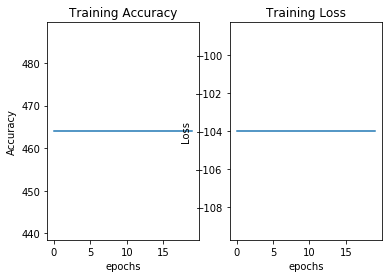

In [222]:
results=my_brain.results()

In [168]:
a=np.array([[1,2,3,4,5],[4,5,6,7,8],[7,8,9,1,2],[11,21,31,41,15],[4,5,6,7,8],[7,8,9,1,2],[12,22,32,42,52],[4,5,6,7,8],[7,8,9,1,2]])
print(a)

[[ 1  2  3  4  5]
 [ 4  5  6  7  8]
 [ 7  8  9  1  2]
 [11 21 31 41 15]
 [ 4  5  6  7  8]
 [ 7  8  9  1  2]
 [12 22 32 42 52]
 [ 4  5  6  7  8]
 [ 7  8  9  1  2]]


In [169]:
permutation = list(np.random.permutation(len(a)))
print(permutation)
new_a = a[permutation,:]
print(new_a)

[4, 5, 6, 8, 2, 0, 1, 7, 3]
[[ 4  5  6  7  8]
 [ 7  8  9  1  2]
 [12 22 32 42 52]
 [ 7  8  9  1  2]
 [ 7  8  9  1  2]
 [ 1  2  3  4  5]
 [ 4  5  6  7  8]
 [ 4  5  6  7  8]
 [11 21 31 41 15]]


In [170]:
abc=[[[[0],[1],[2]]]]

In [171]:
print(abc[0][0][1])

[1]


In [ ]:
np.arange(0,5)

In [ ]:
print(np.floor(560/30))

In [185]:
print(np.log(0.99999))

-1.0000050000287824e-05


In [75]:
abcd=np.zeros([1,10])
print(abcd[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [188]:
464/586

0.7918088737201365